In [65]:
## inaguaral pybaseball notebook !! 
#imports
from pybaseball import statcast
from pybaseball import statcast_pitcher
from pybaseball import statcast_batter
from pybaseball import playerid_lookup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import logging
import polars as pl
%matplotlib inline

In [66]:
#find playerid lookup of zack wheeler
pitcher= playerid_lookup("wheeler","zack")
pitcherid = pitcher.loc[0,"key_mlbam"]
pitcherid = float(pitcherid)
#pull zack wheeler's pitch data from the 2025 season
wheeler_pitches = statcast_pitcher('2025-04-02', '2025-10-09', pitcherid)
wheeler_pitches.shape

Gathering Player Data


(2297, 118)

In [67]:
#convert wheeler_pitches from pandas dataframe to polars dataframe
wheeler_pitches = pl.from_pandas(wheeler_pitches)
#create new column which is the unique ID of the at bat
wheeler_pitches = wheeler_pitches.with_columns(
    pl.concat_str([pl.col("game_pk").cast(pl.Utf8), pl.lit("_"), pl.col("at_bat_number").cast(pl.Utf8)]).alias("ab_id")
)


there are 568 at-bats in these data


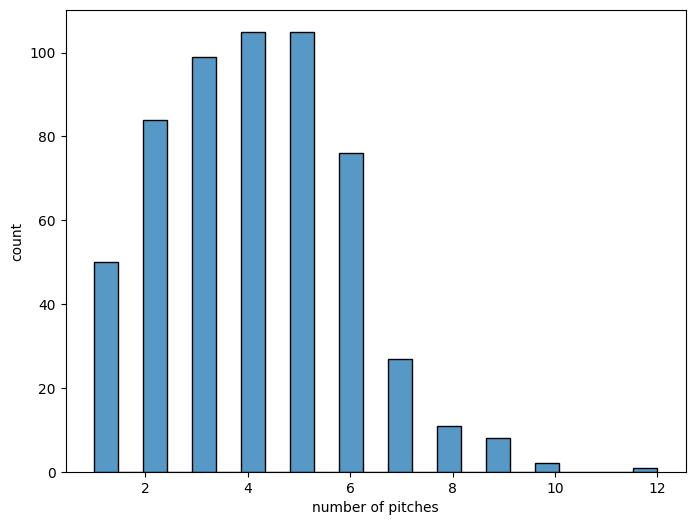

In [76]:
#count unique number of ab_ids so that we can have an idea of how much data we should have
abs = wheeler_pitches["ab_id"].n_unique()
print(f"there are {abs} at-bats in these data")

#plot the distribution of pitches per at bat id
grouped_counts = wheeler_pitches.group_by("ab_id").agg(
    pl.count("ab_id").alias("pitch_count")
)
# print a histogram of the pitch_count column of grouped_counts
plt.figure(figsize=(8,6))
sns.histplot(data=grouped_counts, x="pitch_count")
plt.xlabel("number of pitches")
plt.ylabel("count")
plt.show()

In [84]:
# pitch tunneling, for Zack's most common pitch combinations, what is the most location differential to maximize deception?
#identify two pitch sequences that he uses within at-bats, might want to use the one that gives you a whiff or contact on
#the last pitch of the at bat
# Create a column with the next pitch type in the at-bat
pitch_sequences = wheeler_pitches.with_columns(
    next_pitch_type=pl.col("pitch_type").shift(-1).over("ab_id", order_by="pitch_number")
)


# Filter out the last pitch of each at-bat (where next_pitch_type is null)
pitch_sequences = pitch_sequences.filter(pl.col('next_pitch_type').is_not_null())

# Create a sequence label
pitch_sequences = pitch_sequences.with_columns(
    sequence = pl.concat_str([
        pl.col('pitch_type'),
        pl.lit('→'),
        pl.col('next_pitch_type')
    ])
)

# Count each two-pitch sequence
sequence_counts = pitch_sequences.group_by('sequence').agg(
    pl.count().alias('count')
).sort('count', descending=True)
print(sequence_counts)

shape: (36, 2)
┌──────────┬───────┐
│ sequence ┆ count │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ FF→FF    ┆ 289   │
│ FF→ST    ┆ 103   │
│ SI→SI    ┆ 101   │
│ FF→SI    ┆ 98    │
│ ST→FF    ┆ 87    │
│ …        ┆ …     │
│ FS→SI    ┆ 10    │
│ FC→FC    ┆ 10    │
│ FC→ST    ┆ 8     │
│ FC→SI    ┆ 6     │
│ SI→FC    ┆ 3     │
└──────────┴───────┘


In [90]:
#filter by the last or second to last pitches in a given at bat
#filter by the last or second to last pitches in a given at bat
lastpitches = wheeler_pitches.with_columns(
    max_pitch = pl.col("pitch_number").max().over("ab_id")
).filter(
    (pl.col("pitch_number") == pl.col("max_pitch")) |
    (pl.col("pitch_number") == (pl.col("max_pitch") - 1))
).drop("max_pitch").sort(["ab_id", "pitch_number"])

lastpitches.shape[0]

1086

In [88]:
#calculate the percent of the total that is each of these rows
sequence_counts = sequence_counts.with_columns(
    (pl.col("count") / pl.col("count").sum()).alias("pc_oftotal")
)
sequence_counts
#filter sequence counts to anything more than 5%


sequence,count,pc_oftotal
str,u32,f64
"""FF→FF""",289,0.167149
"""FF→ST""",103,0.059572
"""SI→SI""",101,0.058415
"""FF→SI""",98,0.05668
"""ST→FF""",87,0.050318
…,…,…
"""FS→SI""",10,0.005784
"""FC→FC""",10,0.005784
"""FC→ST""",8,0.004627


In [89]:
# keep only top 5 most frequent two-pitch sequences
top5_sequences = sequence_counts.sort('count', descending=True).head(5)
top5_sequences

sequence,count,pc_oftotal
str,u32,f64
"""FF→FF""",289,0.167149
"""FF→ST""",103,0.059572
"""SI→SI""",101,0.058415
"""FF→SI""",98,0.05668
"""ST→FF""",87,0.050318


statcast pitch type documentation is listed here https://baseballsavant.mlb.com/csv-docs#:~:text=The%20documentation%20for%20Statcast%20Search%20CSV%20data,measured%20in%20feet%20from%20the%20catcher's%20perspective

In [ ]:
# ok so let's try to find the outcomes we want to optimize on
